# Gridding demonstration

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from data_models.polarisation import PolarisationFrame

from processing_library.image.operations import create_w_term_like

from processing_components.visibility.base import create_visibility, create_visibility, create_visibility_from_rows
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, export_image_to_fits
from processing_library.image.iterators import image_raster_iter
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.simulation.testing_support import create_named_configuration
from processing_components.imaging.base import invert_2d, create_image_from_visibility, \
    predict_skycomponent_visibility, advise_wide_field
from processing_components.imaging.imaging_functions import invert_function
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.imaging.weighting import weight_visibility
from processing_components.visibility.iterators import vis_timeslices
import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True


backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct the SKA1-LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2', rmax=500.0)

create_configuration_from_file: Maximum radius 500.0 m includes 190 antennas/stations


We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e7])


reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

create_visibility: 125685 rows, 0.013 GB


Advise on wide field parameters. This returns a dictionary with all the input and calculated variables.

In [5]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 315.4 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003171 (rad) 0.182 (deg)
advise_wide_field: Cellsize 0.001057 (rad) 0.061 (deg)
advice_wide_field: Npixels per side = 486
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 21.0 (s)
advice_wide_field: Time sampling for primary beam = 756.6 (s)
advice_wide_field: Frequency sampling for full image = 24324.9 (Hz)
advice_wide_field: Frequency sampling for primary beam = 875696.5 (Hz)
advice_wide_field: Number of planes in w sta

Plot the synthesized UV coverage.

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


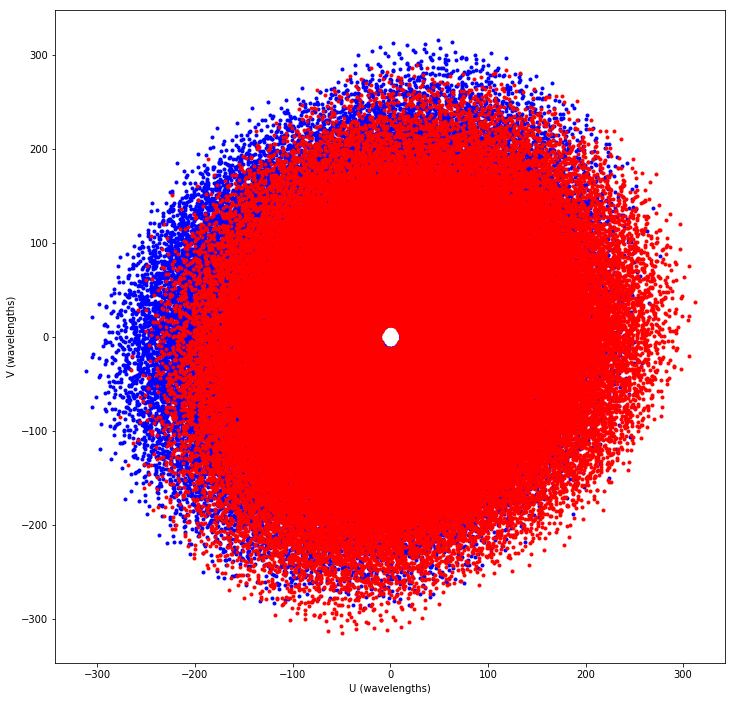

In [6]:
if doplot:
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 1], '.', color='b')
    plt.plot(-vt.data['uvw'][:, 0], -vt.data['uvw'][:, 1], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('V (wavelengths)')
    plt.show()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 311.763675 wavelengths
create_image_from_visibility: Critical cellsize = 0.001604 radians, 0.091890 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_w_term_image: For w = 300.0, field of view = 0.512000, Fresnel number = 19.66
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


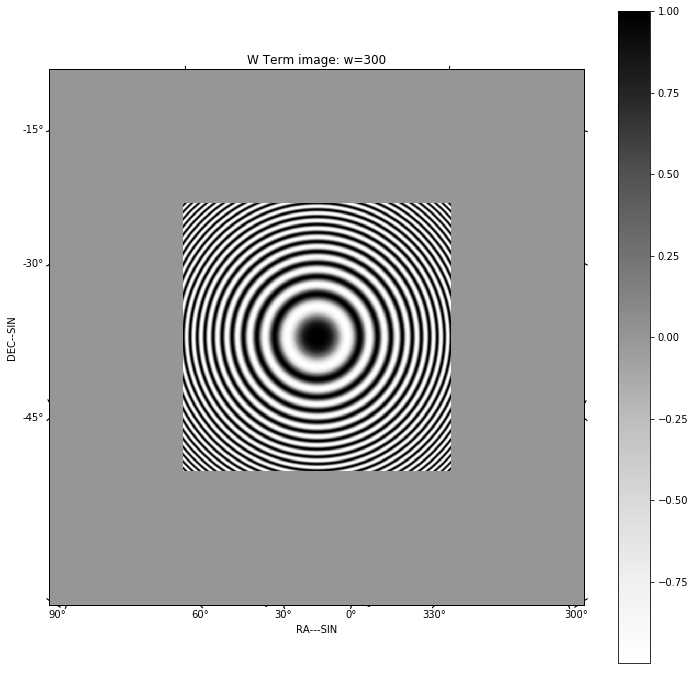

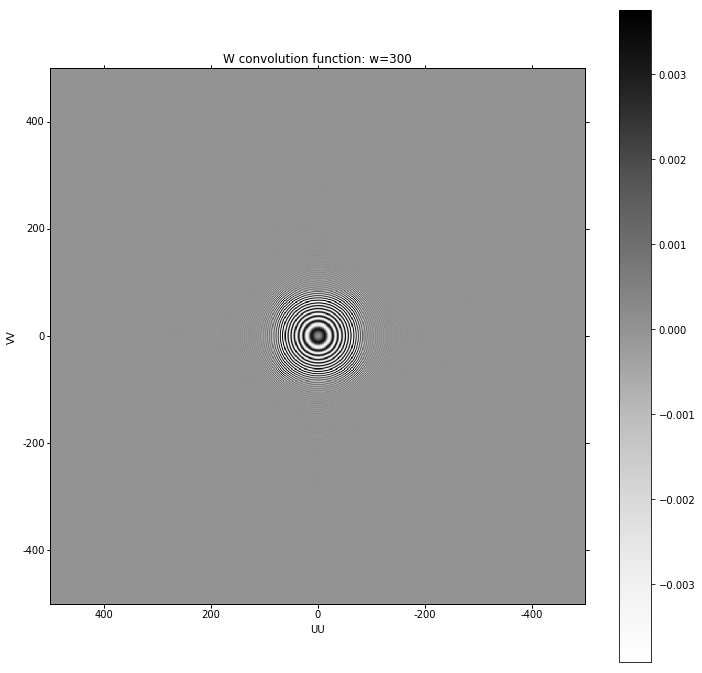

In [7]:
from processing_library.image.operations import create_w_term_like
from processing_components.griddata.operations import fft_image_to_griddata, convert_griddata_to_image
from processing_library.image.operations import fft_image
from processing_library.image.operations import pad_image

model = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)

wterm = create_w_term_like(model, w=300)
wterm=pad_image(wterm, [1,1,1024,1024])
show_image(wterm, title='W Term image: w=300')
plt.show()

wconv = fft_image_to_griddata(wterm)
wconv_image=convert_griddata_to_image(wconv)
show_image(wconv_image, title='W convolution function: w=300')
plt.show()

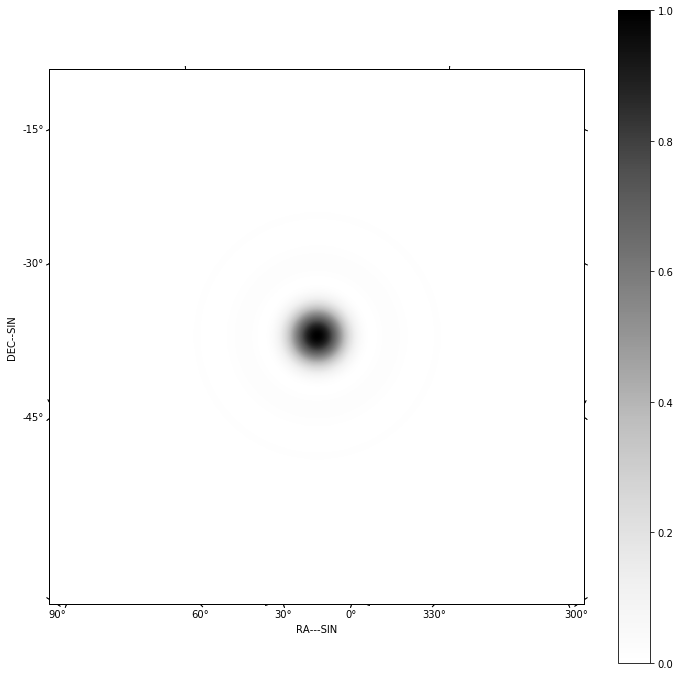

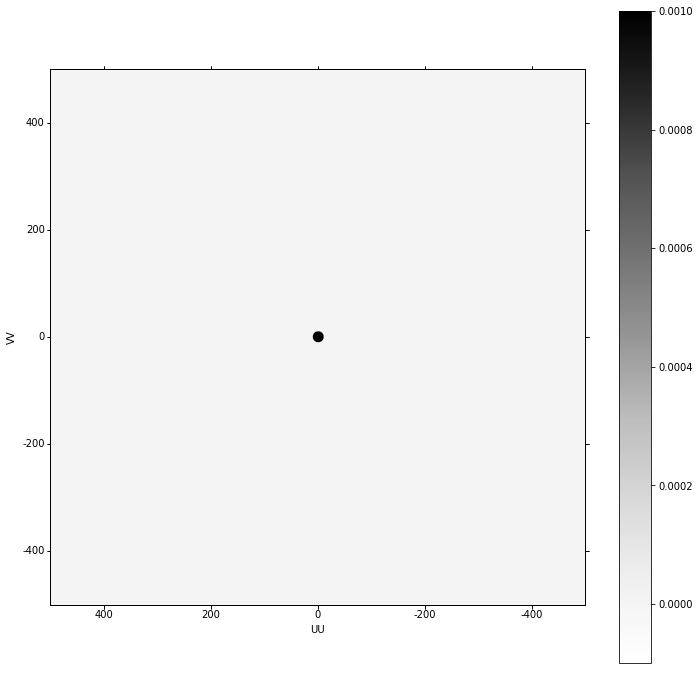

In [8]:
from processing_components.imaging.primary_beams import create_pb, create_pb_generic
pb = create_pb_generic(wterm, diameter=35.0, blockage=0.0)
show_image(pb, vmax=1.0)
plt.show()
aconv = fft_image_to_griddata(pb)
aconv_image=convert_griddata_to_image(aconv)
show_image(aconv_image, vmax=0.001, vmin=-0.0001)
plt.show()

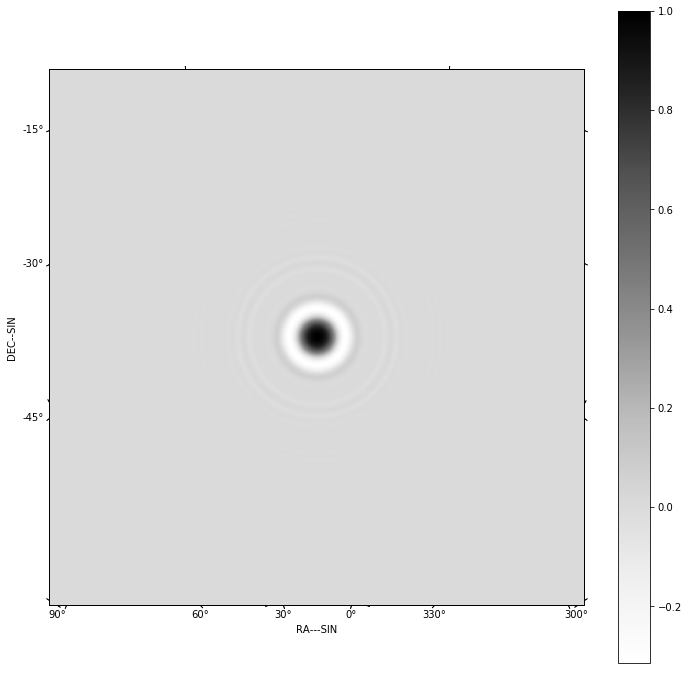

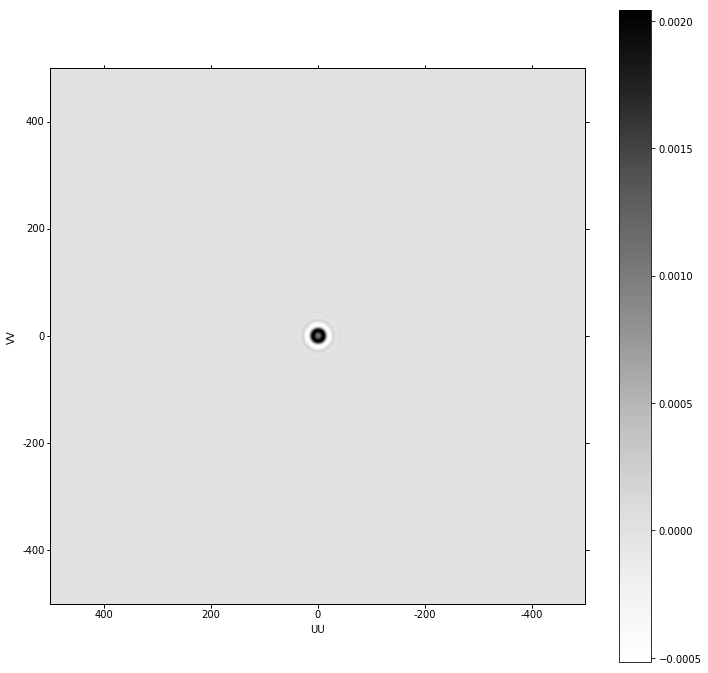

In [9]:
from processing_library.image.operations import copy_image
awterm = copy_image(wterm)
awterm.data = pb.data * wterm.data
show_image(awterm)
plt.show()

awconv = fft_image_to_griddata(awterm)
awconv_image=convert_griddata_to_image(awconv)
show_image(awconv_image)
plt.show()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 311.763675 wavelengths
create_image_from_visibility: Critical cellsize = 0.001604 radians, 0.091890 degrees
create_image_from_visibility: Cellsize          = 0.008000 radians, 0.458366 degrees
create_image_from_visibility: Resetting cellsize 0.008000 radians to criticalcellsize 0.001604 radians
create_w_term_image: For w = 0.0, field of view = 0.410567, Fresnel number = 0.00
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 311.763675 wavelengths
create_image_

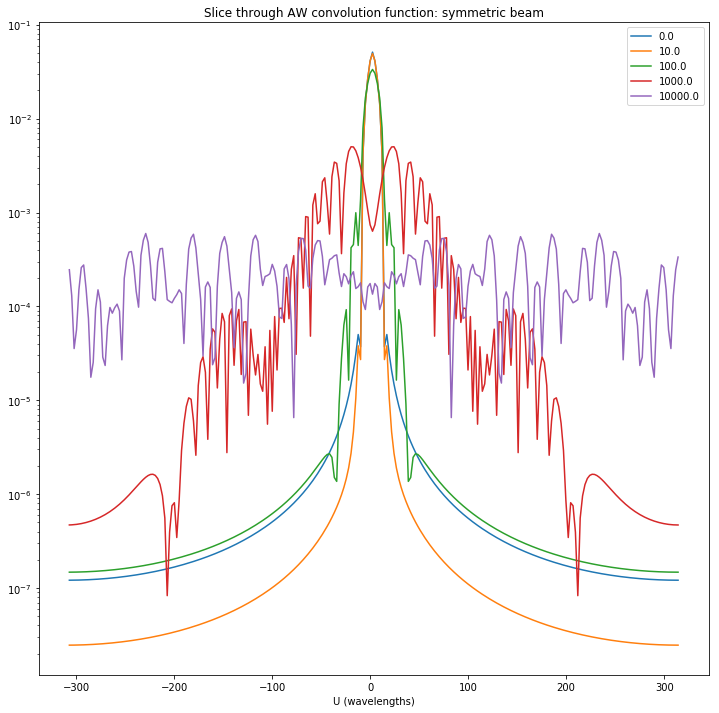

In [15]:
plt.clf()
npixel=256
oversampling=8
for w in [0.0, 10.0, 100.0, 1000.0, 10000.0]:
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001*oversampling, npol=1)
    wterm = create_w_term_like(model, w=w)
    awterm = copy_image(wterm)
    pb = create_pb_generic(wterm, diameter=35.0, blockage=0.0)
    awterm.data = pb.data * wterm.data
    awconv = fft_image_to_griddata(awterm)
    awconv_image=convert_griddata_to_image(awconv)
    u=awconv_image.wcs.sub([1,2]).wcs_pix2world(numpy.arange(npixel), numpy.arange(npixel), 1)[0]
    plt.semilogy(u, numpy.abs(numpy.real(awconv_image.data[0,0,npixel//2,:])), label=str(w))
    plt.title('Slice through AW convolution function: symmetric beam')
    plt.xlabel('U (wavelengths)')
    plt.legend()
plt.savefig('gridding_aw_symmetric_beam.png')

plt.show()


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 311.763675 wavelengths
create_image_from_visibility: Critical cellsize = 0.001604 radians, 0.091890 degrees
create_image_from_visibility: Cellsize          = 0.008000 radians, 0.458366 degrees
create_image_from_visibility: Resetting cellsize 0.008000 radians to criticalcellsize 0.001604 radians
create_w_term_image: For w = 0.0, field of view = 0.410567, Fresnel number = 0.00
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_image_from_visibility: Parsing param

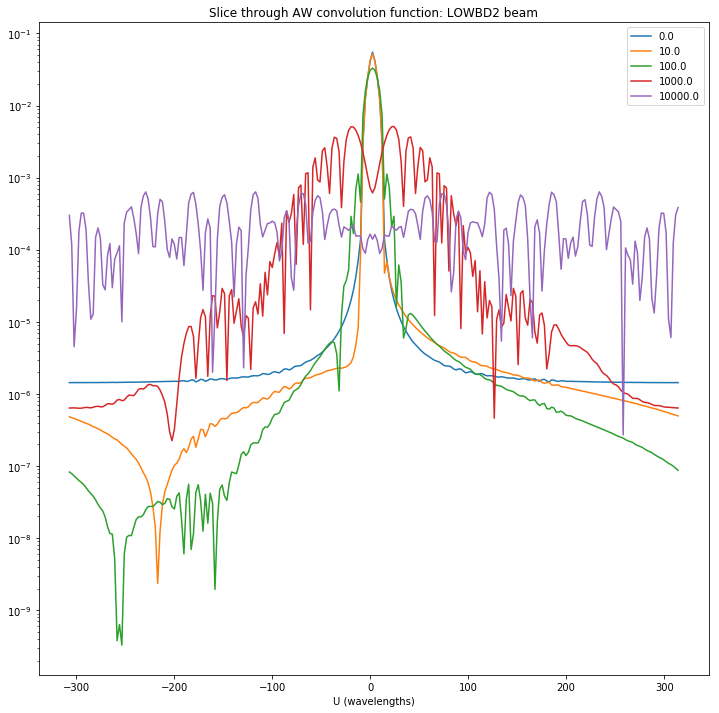

In [14]:
plt.clf()
npixel=256
oversampling=8
for w in [0.0, 10.0, 100.0, 1000.0, 10000.0]:
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001*oversampling, npol=1)
    wterm = create_w_term_like(model, w=w)
    awterm = copy_image(wterm)
    pb = create_pb(wterm, 'LOWBD2')
    awterm.data = pb.data * wterm.data
    awconv = fft_image_to_griddata(awterm)
    awconv_image=convert_griddata_to_image(awconv)
    u=awconv_image.wcs.sub([1,2]).wcs_pix2world(numpy.arange(npixel), numpy.arange(npixel), 1)[0]
    plt.semilogy(u, numpy.abs(numpy.real(awconv_image.data[0,0,npixel//2,:])), label=str(w))
    plt.title('Slice through AW convolution function: LOWBD2 beam')
    plt.xlabel('U (wavelengths)')
    plt.legend()
plt.savefig('gridding_aw_LOWBD2_beam.png')
plt.show()


